#  Using the Replicate API to run text-to-image models
<!-- ---
title: "Image prompting with the Replicate API"
authors: afiaka87 
published_at: 2022-07-21
--- -->

Replicate's new API allows you to easily run inference on many open [text-to-image models](https://replicate.com/collections/text-to-image).



## Setup

In [8]:
#@title Dependencies
from IPython.display import clear_output
%pip -q install replicate clip-retrieval ipyplot

clear_output()
print(f"Dependencies installed.")

Dependencies installed.


## Imports

In [9]:
#@title Imports

import replicate

import ipyplot
import requests
import IPython.display as ipy_display

from PIL import Image as PIL_Image
from pathlib import Path
from typing import List
clear_output()

## Login

In [3]:
# @title Replicate login
import os, getpass

if "REPLICATE_API_TOKEN" not in os.environ:
    print(f"Please go to https://replicate.com/docs/api/getting-started-public for your Replicate API token.")
    # NEVER Store your API key directly in a notebook - this would enable others to gain unauthorized access to your account.
    os.environ["REPLICATE_API_TOKEN"] = getpass.getpass(f"Input Replicate API Token:")
else:
    print(f"API token already set.")


Please go to https://replicate.com/docs/api/getting-started-public for your Replicate API token.
Input Replicate API Token:··········


## Generate an image from text

Using a few lines of python, you can programmatically generate an image via text.

In [ ]:
prompt = "an image of a fresh avocado in the form of a lightbulb"  # @param {type: "string"}
model_name = "afiaka87/glid-3-xl" #@param ["laion-ai/erlich", "laion-ai/ongo", "afiaka87/glid-3-xl"]
seed = 0 # for reproducible output

# @title Helper functions
text2image_model_api = replicate.models.get(model_name)

print(f"Running text2image model {model_name} with prompt {prompt}...")
prediction_generator = text2image_model_api.predict(
    prompt=prompt, seed=seed
) # python generator (yields lazily upon completion)
generated_images = list(prediction_generator)[
    -1
]  # Convert generator to a list to force full generation.
   # Last element = completed outputs (List[Path]) (final batch)

for image_url in generated_images: ipy_display.display(ipy_display.Image(url=image_url)) 

Running text2image model afiaka87/glid-3-xl with prompt an image of a fresh avocado in the form of a lightbulb...


# Upscale your outputs

Replicate has tons of useful models, including "super-resolution" models that can upscale images for you. 

Let's take the output from the previous step and upscale it using `jingyunliang/swinir`.


In [ ]:
#@title Upscale your outputs
upscaling_model_name = "raoumer/srrescgan"
upscaling_model_api = replicate.models.get(upscaling_model_name)
high_res_outputs = upscaling_model_api.predict(image=generated_images[0],)

# Super-Res models can go higher than 1024 px,
# but we manually downsample the display here back to 512 to conceal artifacts and fit output in cell (e.g. width=512)
for high_res_output in high_res_outputs: ipy_display.display(ipy_display.Image(url=high_res_output["file"], width=512))

## Create different variations of an image

Some text-to-image models allow you to pass in an existing image. This produces different variations of your image, with some influence from the specified prompt.

In [4]:
#@title Upload an image
print(f"Upload an image of your own before continuing!")
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import files
    try:
        uploaded = list(files.upload().keys())[0] # path is save as the first key
    except:
        print(f"colab widget failed. If using firefox, you need to disable tracking protection (shield icon in the url bar).") 
else:
    print(f"Using ipywidgets for file upload.")
    from ipywidgets import widgets
    uploaded = widgets.FileUpload()

print("Using uploaded image:")
ipy_display.display(ipy_display.Image(uploaded, width=256))

Upload an image of your own before continuing!


Saving farmhouse.jpeg to farmhouse.jpeg
Using uploaded image:


Sampling initial image for ~87/250 timesteps before beginning text-guided generation.
Running prediction for prompt 'professional painting of a red lakehouse in the style of monet'


/usr/local/lib/python3.7/dist-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



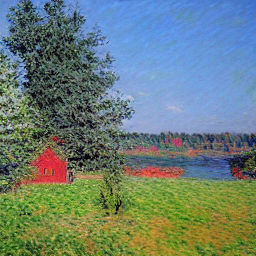
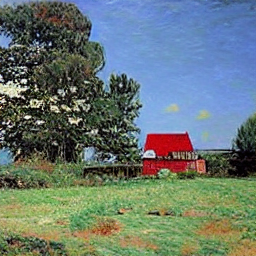
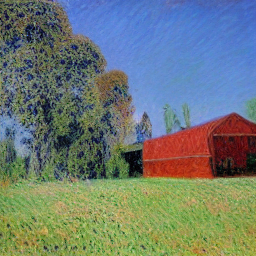


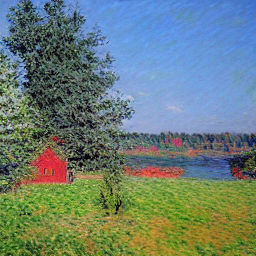
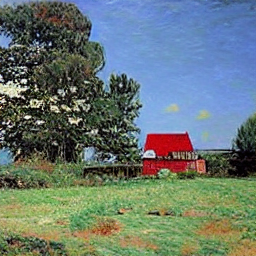
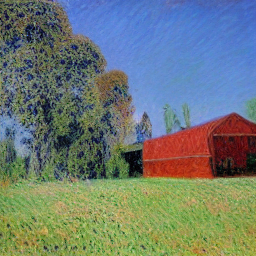

In [10]:
#@title Create different variations of an image { form-width: "512px" }

model_name = "laion-ai/ongo" #@param ["laion-ai/erlich", "laion-ai/ongo", "afiaka87/glid-3-xl"]

image_and_text2image_model_api = replicate.models.get(model_name)
prompt = "professional painting of a red lakehouse in the style of monet"   #@param {type: "string"}
guidance_scale = 10.0 #@param {type: "number"}
total_steps = 250 # max=250, min=30
init_image_percent = 35 #@param {type:"slider", min:0, max:100, step:1}
seed = 0 # for reproducible output

# api uses a decimal, not a percentage.
init_image_fraction = float(init_image_percent / 100) # use nearest int, covers reasonable inputs.
num_init_steps = int(total_steps * init_image_fraction)
print(f"Sampling initial image for ~{num_init_steps}/{total_steps} timesteps before beginning text-guided generation.")

print(f"Running prediction for prompt '{prompt}'")
image2image_predictions = list(
    image_and_text2image_model_api.predict(
        prompt=prompt,
        # batch_size: can use more/less, but won't go past 12
        batch_size=3,
        # steps: using more "steps" improves accuracy at cost of runtime.
        steps=total_steps,
        # init_image: has to be a pathlib.Path, not a string
        init_image=Path(uploaded),
        # init_skip_fraction: steps to be skipped to sample the "init image".
        init_skip_fraction=init_image_fraction,
        # classifier-free guidance scale. Tries to remove noisy/unconditional output by predicting/subtracting it during inference.
        guidance_scale=guidance_scale,
        # seed for reproducibility.
        seed=seed,
    )
)[
    -1
]
images_array = [PIL_Image.open(requests.get(image, stream=True).raw) for image in image2image_predictions]
ipyplot.plot_images(images_array, max_images=20, img_width=256, force_b64=True)